### EfficientNet Model trained with 4 different datasets

In [40]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import EfficientNetB0, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [41]:
# Define the model for transfer learning
Model = EfficientNetB0

In [42]:
# Define the directories containing the Eurosat datasets
data_dirs = {
    90: r"D:\MCA 3rd SEM\Small Industrial Project\DATASET_COMPARE\90",
    80: r"D:\MCA 3rd SEM\Small Industrial Project\DATASET_COMPARE\80",
    70: r"D:\MCA 3rd SEM\Small Industrial Project\DATASET_COMPARE\70",
    60: r"D:\MCA 3rd SEM\Small Industrial Project\DATASET_COMPARE\60"
}

In [43]:
# Define the input shape for the model
input_shape = (64, 64, 3)

In [44]:
# Use ReduceLROnPlateau callback
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

In [45]:
# Create an image data generator with more augmentations and validation split
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # use preprocess_input from vgg16
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # add this line for validation split
)

In [46]:
# Initialize a dictionary to store the accuracy of each model at each stage
accuracy = {}

In [47]:
# Loop over each dataset directory for training
for stage, data_dir in data_dirs.items():
    print(f"Training for stage {stage}")
    
    # Create a train generator with only `stage` images per class
    train_generator = datagen.flow_from_directory(
        data_dir, 
        target_size=(64,64), 
        batch_size=32, 
        subset='training'  # specify this as 'training'
    )

    # Create a validation generator
    validation_generator = datagen.flow_from_directory(
        data_dir, 
        target_size=(64,64), 
        batch_size=32, 
        subset='validation'  # specify this as 'validation'
    )

    # Create a new instance of the model for transfer learning
    base_model = Model(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.5)) # Add dropout layer to reduce overfitting

    # The number of classes is automatically inferred from the subdirectories
    model.add(Dense(train_generator.num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with validation data and callbacks
    history = model.fit(
        train_generator, 
        epochs=10, 
        validation_data=validation_generator,  # use validation_data instead of validation_split
        callbacks=[lr_reduction]
    )

    # Store the accuracy of the model at this stage
    accuracy[stage] = history.history['val_accuracy'][-1]

print("Accuracy for each stage:", accuracy)

Training for stage 90
Found 720 images belonging to 10 classes.
Found 180 images belonging to 10 classes.
Epoch 1/10
23/23 [==============================] - 36s 665ms/step - loss: 1.8563 - accuracy: 0.4222 - val_loss: 1.9440 - val_accuracy: 0.3944 - lr: 0.0010
Epoch 2/10
23/23 [==============================] - 14s 580ms/step - loss: 0.9398 - accuracy: 0.7125 - val_loss: 1.3060 - val_accuracy: 0.5611 - lr: 0.0010
Epoch 3/10
23/23 [==============================] - 11s 482ms/step - loss: 0.6643 - accuracy: 0.7875 - val_loss: 1.2338 - val_accuracy: 0.6611 - lr: 0.0010
Epoch 4/10
23/23 [==============================] - 11s 480ms/step - loss: 0.5178 - accuracy: 0.8431 - val_loss: 1.1951 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 5/10
23/23 [==============================] - 11s 490ms/step - loss: 0.5316 - accuracy: 0.8667 - val_loss: 1.1722 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 6/10
23/23 [==============================] - 11s 478ms/step - loss: 0.3858 - accuracy: 0.8847 - val_loss: 1

Accuracy for each stage: {90: 0.8222222328186035, 80: 0.918749988079071, 70: 0.7142857313156128, 60: 0.8166666626930237}


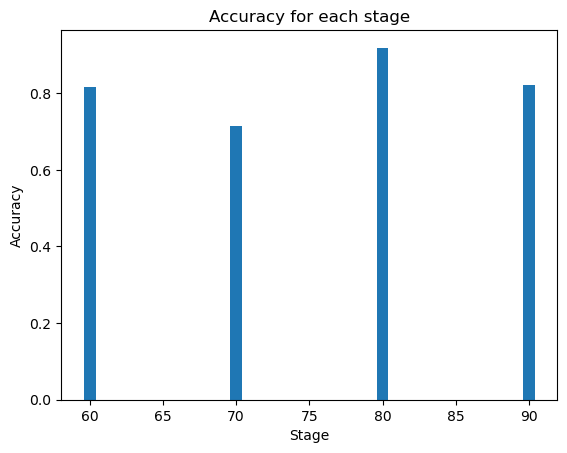

In [48]:
import matplotlib.pyplot as plt

# After training the model and storing the accuracy
print("Accuracy for each stage:", accuracy)

# Create a list of stages and their corresponding accuracies
stages = list(accuracy.keys())
accuracies = list(accuracy.values())

# Create a bar plot
plt.bar(stages, accuracies)
plt.xlabel('Stage')
plt.ylabel('Accuracy')
plt.title('Accuracy for each stage')
plt.show()

In [52]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array


# Define the path to your image for testing
img_path = r"D:\MCA 3rd SEM\Small Industrial Project\DATASET_COMPARE\90\AnnualCrop\AnnualCrop_1.jpg"
# img_path = r'D:\MCA 3rd SEM\Small Industrial Project\DATASET_COMPARE\90\HerbaceousVegetation\HerbaceousVegetation_90.jpg'
# img_path = r"D:\MCA 3rd SEM\Small Industrial Project\DATASET_COMPARE\90\Industrial\Industrial_1.jpg"
# img_path = r"D:\MCA 3rd SEM\Small Industrial Project\DATASET_COMPARE\90\SeaLake\SeaLake_1.jpg"

# Load and preprocess the image
img = load_img(img_path, target_size=input_shape[:2])
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Use the trained model to make a prediction
preds = model.predict(x)

# Get the class labels from the train generator
classes = list(train_generator.class_indices.keys())

# Decode the prediction
predicted_class = np.argmax(preds[0])

print(f'The predicted class is: {classes[predicted_class]}')

1/1 [==============================] - 0s 34ms/step
The predicted class is: AnnualCrop


In [49]:
# Define the path to your directory for testing
dir_path = r"D:\MCA 3rd SEM\Small Industrial Project\TEST"

In [50]:
# Get a list of all image files in the directory
img_files = [f for f in os.listdir(dir_path) if f.endswith('.jpg')]

# Loop over each image file
for img_file in img_files:
    # Load and preprocess the image
    img = load_img(os.path.join(dir_path, img_file), target_size=input_shape[:2])
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the trained model to make a prediction
    preds = model.predict(x)

    # Decode the prediction
    predicted_class = np.argmax(preds[0])

    print(f'The predicted class for {img_file} is: {classes[predicted_class]}')

1/1 [==============================] - 1s 1s/step
The predicted class for AnnualCrop_1.jpg is: PermanentCrop
1/1 [==============================] - 0s 35ms/step
The predicted class for Forest_1.jpg is: Forest
1/1 [==============================] - 0s 39ms/step
The predicted class for HerbaceousVegetation_1.jpg is: HerbaceousVegetation
1/1 [==============================] - 0s 40ms/step
The predicted class for Highway_1.jpg is: Highway
1/1 [==============================] - 0s 35ms/step
The predicted class for Industrial_1.jpg is: Industrial
1/1 [==============================] - 0s 37ms/step
The predicted class for Pasture_1.jpg is: Pasture
1/1 [==============================] - 0s 35ms/step
The predicted class for PermanentCrop_1.jpg is: PermanentCrop
1/1 [==============================] - 0s 34ms/step
The predicted class for Residential_1.jpg is: Residential
1/1 [==============================] - 0s 44ms/step
The predicted class for River_1.jpg is: River
1/1 [========================